# Native Programming

When working with quantum circuits, you'll encounter situations where you need your code to run exactly as written, without the compiler making any optimizations. This is where verbatim compilation becomes essential. There are several use cases: when benchmarking quantum hardware, you need precise control over which specific gates execute on the device since any compiler optimizations could introduce variables that make your performance measurements meaningless. In error mitigation protocols, you might need to insert what looks like redundant operations that a circuit optimizer would normally remove, but these "redundant" steps are actually crucial for techniques like zero-noise extrapolation to work properly. Additionally, calibration and characterization experiments require verbatim execution because you're often testing specific gate implementations or noise properties that woul  be obscured if the compiler substitutes different gates. Advanced quantum protocols like dynamical decoupling or composite pulse sequences also need precise timing and gate ordering preserved exactly as programmed to maintain their effectiveness. To prevent the compiler from modifying your circuits, you can use AWS Braket's `#pragma braket verbatim` directive around the critical sections of your OpenQASM code, or if you're using the Qiskit-Braket provider, simply set `verbatim=True` in your backend's run your circuit as how you intend to.

In [20]:
# General imports
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumCircuit
from qiskit.transpiler.coupling import CouplingMap
from qiskit.visualization import plot_histogram
from qiskit_ionq import GPI2Gate, GPIGate, MSGate

from braket.tracking import Tracker
from qiskit_braket_provider import BraketProvider

t = Tracker().start()

### Function for Plotting Coupling map

In [2]:
def plot_coupling_map(
    coupling_map: CouplingMap,
    title: str = "Coupling Map",
    figsize: tuple[int, int] = (6, 4),
):
    """
    Plots the coupling map of a quantum device using NetworkX's kamada_kawai layout.

    Args:
        coupling_map (CouplingMap): List of tuples representing the edges (qubit connections).
        title (str): Title of the plot (optional).
        figsize (tuple[int, int]): Size of the figure (optional).
    """
    graph = nx.Graph()
    graph.add_edges_from(coupling_map)

    plt.figure(figsize=figsize)
    nx.draw_kamada_kawai(
        graph,
        with_labels=True,
        font_color="white",
        arrows=True,
        arrowsize=30,
    )
    plt.title(title)
    plt.show()

### Set up the Braket Provider

This step initializes the Braket provider and lists all available backends. These are the quantum
devices or simulators that you can use.

In [3]:
provider = BraketProvider()
backends = provider.backends()
print(backends)

[BraketBackend[Ankaa-3], BraketBackend[Aria 1], BraketBackend[Aria 2], BraketBackend[Forte 1], BraketBackend[Forte Enterprise 1], BraketBackend[Garnet], BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]


## Superconducting Quantum Systems

### Rigetti Ankaa-3

#### Native Gates

Retrieve the native gate set supported by the Ankaa-3 device. This includes only those gates that are natively implemented in hardware.

In [4]:
ankaa_3 = provider.get_backend("Ankaa-3")
ankaa_supported_gates = ankaa_3.get_gateset(native=True)
print(ankaa_supported_gates)

{'rx', 'iswap', 'rz'}


#### Coupling Map

This code block extracts and plots the connectivity (coupling map) of qubits for the Ankaa-3 quantum device.

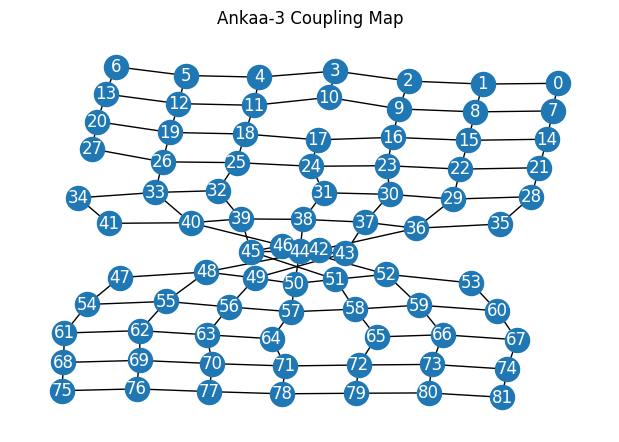

In [5]:
plot_coupling_map(ankaa_3.coupling_map, title="Ankaa-3 Coupling Map")

### IQM Garnet

Retrieve the native gate set supported by the Garnet device. This includes only those gates that are natively implemented in hardware.

In [6]:
garnet = provider.get_backend("Garnet")
garnet_supported_gates = garnet.get_gateset(native=True)
print(garnet_supported_gates)

{'r', 'cz'}


#### Coupling Map

This code block extracts and plots the connectivity (coupling map) of qubits for the Garnet quantum device.

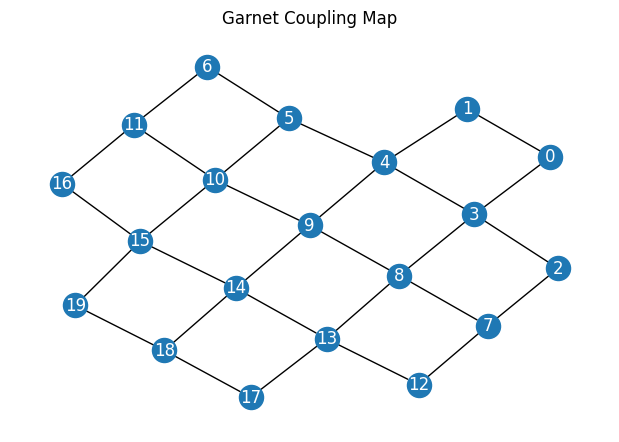

In [7]:
plot_coupling_map(garnet.coupling_map, title="Garnet Coupling Map")

## Trapped-Ion Quantum Systems

### IonQ Aria-1

#### Native Gates

Retrieve the native gate set supported by the Aria-1 device. This includes only those gates that are natively implemented in hardware.

In [16]:
aria_1 = provider.get_backend("Aria 1")
aria_supported_gates = aria_1.get_gateset(native=True)
print(aria_supported_gates)

{'gpi2', 'gpi', 'ms'}


#### Coupling Map

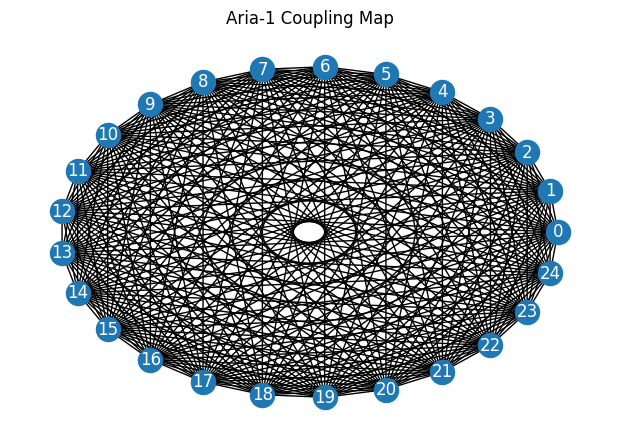

In [17]:
plot_coupling_map(aria_1.coupling_map, title="Aria-1 Coupling Map")

#### Running Normally on Aria-1 Quantum Hardware

Let's try creating bell state $$|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$  Can be created using a simple two-gate quantum circuit. Starting with both qubits in the $|00\rangle$ state, first apply a Hadamard gate to the first qubit to create the superposition on $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, then apply a CNOT gate with the first qubit as control and second as target. The Hadamard gate puts the first qubit into an equal superposition of $|0\rangle$ and $|1\rangle$, while the subsequent CNOT gate entangles the qubits by flipping the second qubit only when the first is in state $|1\rangle$, resulting in the maximally entangled Bell state where both qubits are perfectly correlated.

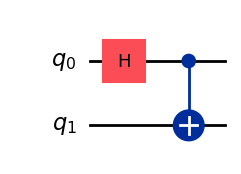

In [10]:
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.draw(output="mpl")

In [11]:
task = aria_1.run(circuit, shots=10)

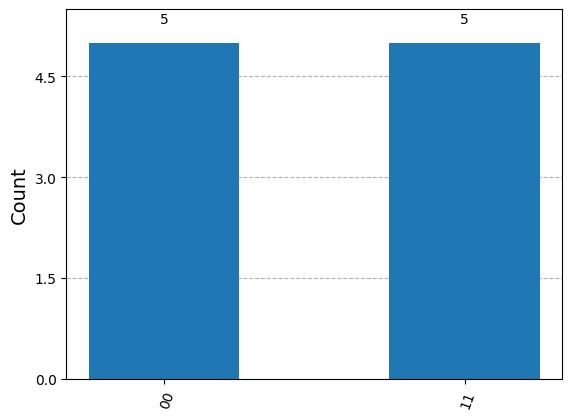

In [12]:
plot_histogram(task.result().get_counts())

When circuits use non-native gates, they must be automatically decomposed into hardware-supported operations, which increases circuit depth, introduces additional noise, and reduces fidelity. By designing circuits with native gates in mind, programmers can minimize decomposition overhead, reduce execution time, and achieve higher-quality results. Additionally, using native gates provides "what-you-submit-is-what-you-get control" by bypassing compiler optimizations.

#### Running with Native Gates & Verbatim Compilation

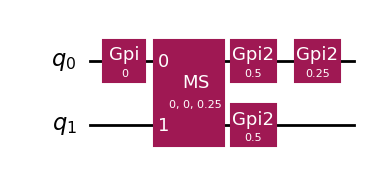

In [13]:
native_circuit = QuantumCircuit(2)
native_circuit.append(GPIGate(0), [0])
native_circuit.append(MSGate(0, 0, 0.25), [0, 1])
native_circuit.append(GPI2Gate(0.5), [1])
native_circuit.append(GPI2Gate(0.5), [0])
native_circuit.append(GPI2Gate(0.25), [0])
native_circuit.draw("mpl")

In [ ]:
task = aria_1.run(native_circuit, verbatim=True)
plot_histogram(task.result().get_counts())

## Conclusion

This notebook introduced the basic functionality of verbatim compilation of Amazon Braket, that allows you to run circuits or subcircuits to be executed exactly as defined without any compiler modifications.

In [15]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum "
    "processing unit (QPU) task usage. Estimated charges shown may differ from your actual "
    "charges. Estimated charges do not factor in any discounts or credits, and you may "
    "experience additional charges based on your use of other services such as Amazon "
    "Elastic Compute Cloud (Amazon EC2).",
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD",
)

Quantum Task Summary
{'arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1': {'shots': 10, 'tasks': {'COMPLETED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 1.100 USD
